# Analysis of bacterial cell oritetation in microchannels
Analyse cell oritentation distribution in microchannels simulated with `CellModeller` [1].

## Purpose
Compare simualtion and experimental cell oritentation data to calibrate simulation parameters.

## Methodology
1. Read `.pickle` file into dictionary with `pickle` module.
2. Plot cell oritentation histogram for each simulation step.
3. Coallete all histograms into one interactive figure.

## WIP - improvements
Use this section only if the notebook is not final.

## Notable TODOs:

- Load multiple `.pickle` files. Store in a dictionary `{simulation_step: cell_state}`
- Plot oritentation histogram for each simulation step.
- Use `plotly` to visualize multiple steps in one figure.
- Copy model file to output directory.

## Results
`norm` - cell orientation vector. **Note** Already normalized. 

## Suggested next steps
- Load, process and analyse experimetal data
- Compare experimetal and simualtion data plots

# Setup
## Library import

In [1]:
import os
from os.path import join as join_paths, basename as get_basename
import glob

import pickle
import numpy as np
from scipy.stats import gaussian_kde

from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

In [2]:
os.chdir("/home/i/igors-dubanevics/projects/bacteria-microchannel")
os.getcwd()

'/home/i/igors-dubanevics/projects/bacteria-microchannel'

## Parameter definition

In [3]:
data_dir_path = "data/microch_30x4-22-11-29-09-57"

out_dir_path = join_paths("scratch", get_basename(data_dir_path))

# Time-step
dt = 0.005 # [min]

## Pre-data import

In [4]:
# Create output dir
os.makedirs(out_dir_path, exist_ok=True)

## Data import

In [5]:
# Store data in a dictionary of form {step_number: cell_state}
cell_states = {}

# Get data from saved pickle files
filenames = sorted(glob.glob(join_paths(data_dir_path, 'step-*.pickle')))
for filename in filenames:
    # Extract simualtion step number from a filename
    step_num = int(get_basename(filename).replace(".pickle","").replace("step-",""))
    data = pickle.load(open(filename,'rb'))
    cs = data['cellStates']
    cell_states[step_num] = cs

## Data processing

In [6]:
lengths = {}
postions = {}
orients = {}

orient_per_cell = {}

for step_num, cell_state in cell_states.items():
    # Make some convenient data arrays from cell properties
    length = np.array([cell.length for (id,cell) in cell_state.items()]) # [um]
    # Postion in respect to the center of simulation
    # Assume it's center of the channel (0,0)
    pos = np.array([cell.pos for (id,cell) in cell_state.items()])
    # Normalized orientation vector
    orient = np.array([cell.dir for (id,cell) in cell_state.items()])

    # Orientation per cell
    for (id,cell) in cell_state.items():
        if id in orient_per_cell.keys():
            orient_per_cell[id] = np.append(orient_per_cell[id], [cell.dir], axis=0)
        else:
            orient_per_cell[id] = np.array([cell.dir])

    lengths[step_num] = length
    postions[step_num] = pos
    orients[step_num] = orient

In [7]:
# Calculate angle in respect to a channel
angles_per_step = {}
# Unit-vector parallel to the channel (pointing left-to-right)
x_norm = np.array((1,0,0), dtype=float)
for step_num, orient in orients.items():
    # Dot product with a unit-vector parallel to channel
    inner_prods = np.inner(x_norm,orient)
    # Dot product to radians
    rads = np.arccos(inner_prods)
    # Convert radians to degrees
    angles_per_step[step_num] = np.rad2deg(rads)

In [8]:
angles = np.array([angles for (step_num, angles) in angles_per_step.items()], dtype=object)
angles = np.concatenate(angles).reshape(-1)
np.sort(angles)

array([ 0.        ,  0.        ,  0.        , ..., 85.71279357,
       85.76372411, 85.76810312])

In [9]:
# Calculate angle in respect to a channel
angles_per_cell = {}

# Unit-vector parallel to the channel (pointing left-to-right)
x_norm = np.array((1,0,0), dtype=float)

for id, orient in orient_per_cell.items():
    # Dot product with a unit-vector parallel to channel
    inner_prods = np.inner(x_norm,orient)
    # Dot product to radians
    rads = np.arccos(inner_prods)
    # Convert radians to degrees
    angles_per_cell[id] = np.rad2deg(rads)

In [10]:
# Average angle per cell for whole simulation time
avg_angles = np.array([np.average(angles) for (id, angles) in angles_per_cell.items()])

In [11]:
if len(np.where(avg_angles == 0.0)) == 0:
    avg_angles_double = np.concatenate([-avg_angles,avg_angles])
else:
    x = np.delete(avg_angles, np.where(avg_angles == 0.0)[0])
    avg_angles_double = np.concatenate([-x,avg_angles])
avg_angles_double

array([-0.65235955, -0.94467359, -2.1456062 , ...,  0.00424628,
        0.        ,  0.0119397 ])

In [14]:
len(avg_angles)

634

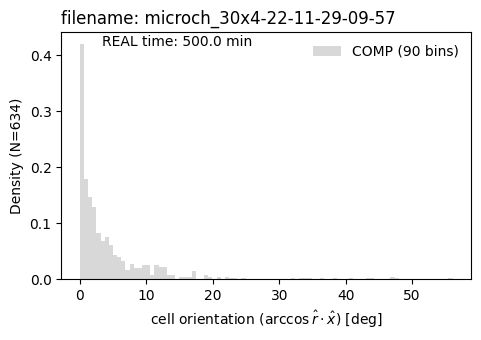

In [17]:
# Plot histograms of some cell properties

# Orientation
fig, ax = plt.subplots(figsize=(5,3.5))
plt.title("filename: {}".format(get_basename(data_dir_path)), loc='left')
bin_num = 90
ax.hist(avg_angles, bin_num, fc='gray', histtype='stepfilled', alpha=0.3, 
    density=True, label='COMP ({:d} bins)'.format(bin_num))
# ax.plot(x_grid, angles_kde[key](x_grid), linewidth=2, label='KDE')

plt.xlabel(r"cell orientation ($\arccos{\hat{r}\cdot\hat{x}}$) [deg]")
plt.ylabel("Density (N={:d})".format(len(avg_angles)))
plt.tight_layout()

# Convert simualtion time into real time
plt.text(.1, .99, "REAL time: {:.1f} min".format(500), ha='left', va='top', transform=ax.transAxes)

plt.legend(loc='upper right', frameon=False)

# Save figure
for ext in ['png']:
    fig_outname =  "orient.{ext}".format(ext=ext)
    fig.savefig(join_paths(out_dir_path, fig_outname), dpi=300)


In [27]:
# Perform Kernel Desity Estimation (KDE)
kde = gaussian_kde(avg_angles_double, bw_method='scott', weights=None)
x_grid = np.linspace(-90,90,100)

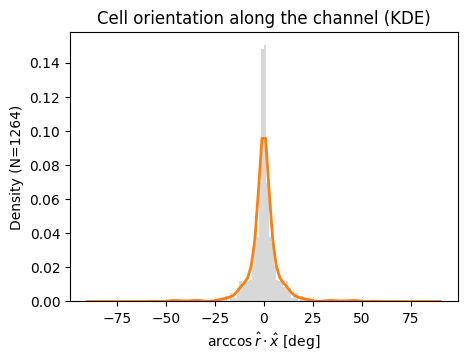

In [30]:
fig, ax = plt.subplots(figsize=(5,3.5))
plt.title("Cell orientation along the channel (KDE)")
ax.hist(avg_angles_double, 90, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.plot(x_grid, kde(x_grid), linewidth=2)

plt.xlabel(r"$\arccos{\hat{r}\cdot\hat{x}}$ [deg]")
plt.ylabel("Density (N={:d})".format(len(avg_angles_double)))
fig.savefig(join_paths(out_dir_path,'oritent_hist.pdf'), dpi=300)
# plt.close()

In [ ]:
# Plot histograms of some cell properties
fig = px.histogram(angles[990], 
    title="Cell orientation along x-axis")
fig.update_layout(bargap=0.2,
    xaxis={"title":  "Orientation [rad]"},
    yaxis={"title":  "Count (N=%d)"%(len(angles[990]))})
fig.show()

In [ ]:
# Plot histograms of some cell properties

# Length
plt.figure(figsize=(5,3.5))
plt.title('Cell length')
plt.hist(lengths, edgecolor='black', color='gray')
plt.xlabel('$\mu m$')
plt.ylabel('Count (N=%d)'%(len(cs)))
plt.savefig(join_paths(out_dir_path, 'length_hist.pdf'), dpi=300)

# Distance from origin
plt.figure(figsize=(5,3.5))
plt.title('Distance from origin')
plt.hist(np.sqrt(pos[:,0]**2+pos[:,1]**2), edgecolor='black', color='gray')
plt.xlabel('$\mu m$')
plt.ylabel('Count (N=%d)'%(len(cs)))
plt.savefig(join_paths(out_dir_path, 'pos_hist.pdf'), dpi=300)

## References
We report here relevant references:
1. https://github.com/cellmodeller/CellModeller
2. 